<b>Segmenting and Clustering Neighborhoods in Toronto</b>

In this assignment, I will explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readily available on the internet.
For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. I will scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format.
Once the data is in a structured format, I will explore and cluster the neighborhoods in the city of Toronto.

In [5]:
!pip install folium

     |████████████████████████████████| 102kB 7.8MB/s ta 0:00:011


In [7]:
!pip install beautifulsoup4

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

The neighborhood data for Toronto is available on [https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M]

We will scrape this page using Beautifulsoup library and transform it into a dataset


In [9]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

resp = requests.get(url)
toronto_html = BeautifulSoup(resp.content)

In [10]:
soup = BeautifulSoup(str(toronto_html))

In [11]:
neighborhood_table = soup.find('table')

In [12]:
table_str = str(neighborhood_table.extract())

In [13]:
toronto_df = pd.read_html(table_str)[0]

In [14]:
toronto_df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [15]:
toronto_df.columns = ['PostalCode'] + list(toronto_df.columns)[1:]

In [16]:
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [17]:
toronto_df.shape

(180, 3)

In [18]:
toronto_df.Borough.value_counts()

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
East York            5
York                 5
Mississauga          1
Name: Borough, dtype: int64

In [19]:
borough_na = toronto_df[toronto_df.Borough == 'Not assigned']
toronto_df.drop(borough_na.index, inplace=True)

In [20]:
toronto_df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [21]:
toronto_df.shape

(103, 3)

Next, I will combine neighborhoods with the same postal code into one row

In [22]:
toronto_df = toronto_df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda x: ', '.join(x)).to_frame()


In [23]:
toronto_df.reset_index(inplace=True)
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Let's check whether all Neighorhoods are valid


In [24]:
toronto_df[toronto_df.Neighborhood == "Not assigned"]

,PostalCode,Borough,Neighborhood


The empty dataframe indicates there are no neighborhoods in the dataset which have a borough name but no neighborhood name.

In [25]:
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [26]:
toronto_df.shape


(103, 3)

Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In [27]:
geo_url = "https://cocl.us/Geospatial_data"

geocode_df = pd.read_csv(geo_url)
geocode_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geocode_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [28]:
toronto_df = pd.merge(toronto_df, geocode_df, on='PostalCode')
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Explore Toronto dataset

In [29]:
toronto_latlong = [43.653225, -79.383186]


In [31]:
# create map of Manhattan using latitude and longitude values
toronto_map = folium.Map(location=toronto_latlong, zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#2E7D32',
        fill=True,
        fill_color='#FFEB3B',
        fill_opacity=0.75,
        parse_html=False).add_to(toronto_map)

<h1><b>Foursqaure API</h1></b>


I've stored my foursqaure credentials in a file which I am reading below


In [32]:
search_url = 'https://api.foursquare.com/v2/venues/search'

In [33]:
CLIENT_ID = 'ZVKPBBUCLN1WRF2WDHGBRLX4NGQ5L2TJC2BQKJ01AXUCQJUQ' # your Foursquare ID
CLIENT_SECRET = 'RIS32WD234K3RUCMXWUNXKLC5QEV25LHUGVT5ZWA4DP40PRC' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZVKPBBUCLN1WRF2WDHGBRLX4NGQ5L2TJC2BQKJ01AXUCQJUQ
CLIENT_SECRET:RIS32WD234K3RUCMXWUNXKLC5QEV25LHUGVT5ZWA4DP40PRC


<b>Let's explore one of the boroughs in our dataframe.</b>


In [34]:
toronto_df.loc[0, 'Borough']


'Scarborough'

In [35]:
print('Latitude and longitude values of {} are {}, {}.'.format(toronto_df.loc[0, 'Borough'], 
                                                               toronto_df.loc[0, 'Latitude'], 
                                                               toronto_df.loc[0, 'Longitude']))

Latitude and longitude values of Scarborough are 43.806686299999996, -79.19435340000001.


<b><i>Now, let's explore the Foursquare API using Scarborough</b></i>

In [36]:
params = dict(
  client_id=CLIENT_ID,
  client_secret=CLIENT_SECRET,
  v=VERSION,
  ll=f"{toronto_df.loc[0, 'Latitude']}, {toronto_df.loc[0, 'Longitude']}",
  radius=500,
  limit=100
)

In [37]:
resp = requests.get(url=search_url, params=params)
data = resp.json()

Let's see how one venue data looks like....


In [38]:
data['response']['venues'][0]

{'id': '4e389459b61c438b547e8ed4',
 'name': 'Rouge Park - Woodland Trail',
 'location': {'lat': 43.80178186082014,
  'lng': -79.20042735921538,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.80178186082014,
    'lng': -79.20042735921538}],
  'distance': 732,
  'cc': 'CA',
  'country': 'Canada',
  'formattedAddress': ['Canada']},
 'categories': [{'id': '4bf58dd8d48988d159941735',
   'name': 'Trail',
   'pluralName': 'Trails',
   'shortName': 'Trail',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/hikingtrail_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1589286778',
 'hasPerk': False}

Now, let's write a function to extract important data from venue object. We can reuse the function for other boroughs as well intead of repeating the same code again and again.

In [39]:
def get_venues(neighborhood, lat, long, limit=100, radius=250):
    params = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v=VERSION,
        ll=f"{lat}, {long}",
        radius=radius,
        limit=limit
    )
    venues = []
    data = requests.get(url=search_url, params=params).json()
    for v in data['response']['venues']:
        venues.append([neighborhood, lat, long, v['name'], v['location']['lat'], v['location']['lng'], 
                       ', '.join(x['name'] for x in v['categories'])])
    return venues

In [41]:
nbr_venues_df = pd.DataFrame()
columns=['Neighborhood', 'NeighborhoodLat', 'NeighborhoodLong', 'VenueName', 'VenueLat', 'VenueLong', 'VenueCategory']

In [42]:
for name, lat, long in zip(toronto_df.Neighborhood, toronto_df.Latitude, toronto_df.Longitude):
    nbr_venues_df = nbr_venues_df.append(get_venues(name, lat, long))

In [44]:
nbr_venues_df.columns = columns


In [46]:
nbr_venues_df.head()
`

,Neighborhood,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
0,"Malvern, Rouge",43.806686,-79.194353,Rouge Park - Woodland Trail,43.801782,-79.200427,Trail
1,"Malvern, Rouge",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
2,"Malvern, Rouge",43.806686,-79.194353,Shell,43.803227,-79.192414,Gas Station
3,"Malvern, Rouge",43.806686,-79.194353,Kaycan - SCARBOROUGH,43.806768,-79.197875,Building
4,"Malvern, Rouge",43.806686,-79.194353,Subway,43.801095,-79.200304,Sandwich Place


In [48]:
nbr_venues_df.shape

(9867, 7)

Since we have limited number of request quota on Foursquare free tier, we will save the dataframe to a csv file, so that we can continue from here at a later point in time, if we need to close the notebook.


In [51]:
nbr_venues_df.to_csv('toronto_boroughs_and_venues.csv')


<h1><b>Analyse Venue Data</h1></b>   

In [53]:
nbr_venues_df = pd.read_csv('toronto_boroughs_and_venues.csv')
nbr_venues_df.drop(['Unnamed: 0'], axis=1, inplace=True)
nbr_venues_df.head()

,Neighborhood,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
0,"Malvern, Rouge",43.806686,-79.194353,Rouge Park - Woodland Trail,43.801782,-79.200427,Trail
1,"Malvern, Rouge",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
2,"Malvern, Rouge",43.806686,-79.194353,Shell,43.803227,-79.192414,Gas Station
3,"Malvern, Rouge",43.806686,-79.194353,Kaycan - SCARBOROUGH,43.806768,-79.197875,Building
4,"Malvern, Rouge",43.806686,-79.194353,Subway,43.801095,-79.200304,Sandwich Place


We will remove rows with Empty VenueCategory


In [54]:
nbr_venues_df.VenueCategory.replace('', np.nan, inplace=True)
nbr_venues_df.dropna(inplace=True)
nbr_venues_df.shape

(8792, 7)

Let's check the frequency of each Venue Category


In [55]:
nbr_venues_df.VenueCategory.value_counts()


Office                                      580
Residential Building (Apartment / Condo)    327
Building                                    284
Salon / Barbershop                          174
Coffee Shop                                 172
Park                                        164
Doctor's Office                             160
Automotive Shop                             159
Medical Center                              157
Church                                      153
Bank                                        145
Dentist's Office                            143
Convenience Store                           109
Pizza Place                                 107
School                                      100
Café                                         99
Bus Line                                     97
Pharmacy                                     80
Gas Station                                  78
Bus Stop                                     74
Bakery                                  

Let's drop the venue categories which are not common, since they may add too much noise to our data


In [56]:
# Dropping rows i.e categories which are mentioned less than 15 times in the dataset
common_categories = nbr_venues_df.VenueCategory.unique()[nbr_venues_df.VenueCategory.value_counts()>15]

In [57]:
nbr_venues_df = nbr_venues_df[nbr_venues_df.VenueCategory.isin(common_categories)]
nbr_venues_df.shape

(6393, 7)

Now we will analyze how many venues of our interest are present in each neighbour hood


In [58]:
from IPython.core.display import HTML

display(HTML(nbr_venues_df.groupby('Neighborhood').count().to_html()))

,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
Neighborhood,,,,,,
Agincourt,75,75,75,75,75,75
"Alderwood, Long Branch",66,66,66,66,66,66
"Bathurst Manor, Wilson Heights, Downsview North",71,71,71,71,71,71
Bayview Village,71,71,71,71,71,71
"Bedford Park, Lawrence Manor East",63,63,63,63,63,63
Berczy Park,60,60,60,60,60,60
"Birch Cliff, Cliffside West",61,61,61,61,61,61
"Brockton, Parkdale Village, Exhibition Place",78,78,78,78,78,78
Business reply mail Processing Centre,46,46,46,46,46,46


The least number of venues is:


In [59]:
nbr_venues_df.groupby('Neighborhood').count().VenueCategory.min()


13

So, for clustering, we will consider Top 10 venue categories in each neighborhood as features.
We will do one-hot encoding of the VenueCategory column to convert them to features

In [60]:
# add neighborhood column back to dataframe
category_onehot = pd.get_dummies(nbr_venues_df.VenueCategory)
category_onehot['Neighborhood'] = nbr_venues_df.Neighborhood

# move neighborhood column to the first column
fixed_columns = [category_onehot.columns[-1]] + list(category_onehot.columns[:-1])
category_onehot = category_onehot[fixed_columns]

In [61]:
category_onehot.head()


,Neighborhood,African Restaurant,Art Gallery,Arts & Crafts Store,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,...,Tattoo Parlor,Tech Startup,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Veterinarian,Winery,Yoga Studio,Zoo Exhibit
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
category_onehot.shape


(6393, 130)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [63]:
category_onehot = category_onehot.groupby('Neighborhood').mean().reset_index()
category_onehot

,Neighborhood,African Restaurant,Art Gallery,Arts & Crafts Store,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,...,Tattoo Parlor,Tech Startup,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Veterinarian,Winery,Yoga Studio,Zoo Exhibit
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026667,0.160000,0.013333,...,0.000000,0.026667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Alderwood, Long Branch",0.000000,0.000000,0.015152,0.000000,0.000000,0.015152,0.000000,0.015152,0.030303,...,0.000000,0.015152,0.015152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.000000,0.014085,0.000000
3,Bayview Village,0.000000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.014085,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.015873,0.000000
5,Berczy Park,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.016667,0.016667,...,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.016393,0.000000,0.000000,0.016393,0.016393,0.016393,0.016393,0.000000,...,0.000000,0.016393,0.016393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.012821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.102564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Business reply mail Processing Centre,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.021739,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.021739
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Let's print each neighborhood along with the top 5 most common venues


In [64]:
num_top_venues = 5

for nbrhood in category_onehot['Neighborhood']:
    print("---- "+nbrhood+" ----")
    temp = category_onehot[category_onehot['Neighborhood'] == nbrhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
              venue  freq
0   Automotive Shop  0.16
1          Building  0.11
2            Office  0.11
3            Church  0.05
4  Storage Facility  0.04


---- Alderwood, Long Branch ----
               venue  freq
0             Office  0.12
1        Gas Station  0.05
2     Medical Center  0.05
3  Convenience Store  0.05
4   Dentist's Office  0.05


---- Bathurst Manor, Wilson Heights, Downsview North ----
                                      venue  freq
0                           Doctor's Office  0.14
1  Residential Building (Apartment / Condo)  0.08
2                            Medical Center  0.07
3                                    Office  0.07
4                                      Bank  0.06


---- Bayview Village ----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.10
1                                    Church  0.08
2                           Doctor's Office  0.07
3                                    Of

<b>Let's put that into a pandas dataframe


In [65]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [66]:
indicators = ['st', 'nd', 'rd']
num_top_venues = 10

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nbr_venues_sorted_df = pd.DataFrame(columns=columns)
nbr_venues_sorted_df['Neighborhood'] = category_onehot['Neighborhood']

for ind in np.arange(category_onehot.shape[0]):
    nbr_venues_sorted_df.iloc[ind, 1:] = return_most_common_venues(category_onehot.iloc[ind, :], num_top_venues)

nbr_venues_sorted_df.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Automotive Shop,Building,Office,Church,Doctor's Office,Coffee Shop,Storage Facility,Auto Garage,Gas Station,Rental Car Location
1,"Alderwood, Long Branch",Office,Bank,Gas Station,Convenience Store,Salon / Barbershop,Dentist's Office,Medical Center,BBQ Joint,Factory,Breakfast Spot
2,"Bathurst Manor, Wilson Heights, Downsview North",Doctor's Office,Residential Building (Apartment / Condo),Office,Medical Center,Bank,Salon / Barbershop,Building,Convenience Store,Dentist's Office,Non-Profit
3,Bayview Village,Residential Building (Apartment / Condo),Church,Doctor's Office,Office,Salon / Barbershop,Bank,Dog Run,Medical Center,Playground,Optical Shop
4,"Bedford Park, Lawrence Manor East",Salon / Barbershop,Italian Restaurant,Spa,Dentist's Office,Office,Medical Center,Hobby Shop,Sandwich Place,Mobile Phone Shop,Nail Salon


<b><h1>Clustering Neighborhoods

In [69]:
from sklearn.cluster import KMeans

Let's assume we can cluster neighborhoods into three types based on venue categories. We will use 'Elbow' method later to find the best number of clusters


In [70]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)


In [71]:
X = category_onehot.drop(['Neighborhood'], axis=1)
X.head()

,African Restaurant,Art Gallery,Arts & Crafts Store,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bakery,...,Tattoo Parlor,Tech Startup,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Veterinarian,Winery,Yoga Studio,Zoo Exhibit
0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.026667,0.160000,0.013333,0.000000,...,0.0,0.026667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.015152,0.000000,0.0,0.015152,0.000000,0.015152,0.030303,0.000000,...,0.0,0.015152,0.015152,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.014085,0.0,0.014085,0.0
3,0.0,0.0,0.000000,0.014085,0.0,0.000000,0.000000,0.014085,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.014085,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.015873,...,0.0,0.000000,0.015873,0.0,0.0,0.0,0.000000,0.0,0.015873,0.0


In [72]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 2, 0, 2, 0, 0], dtype=int32)

In [73]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [74]:
scores = [get_inertia(x) for x in range(2, 21)]


Text(0, 0.5, 'Error')

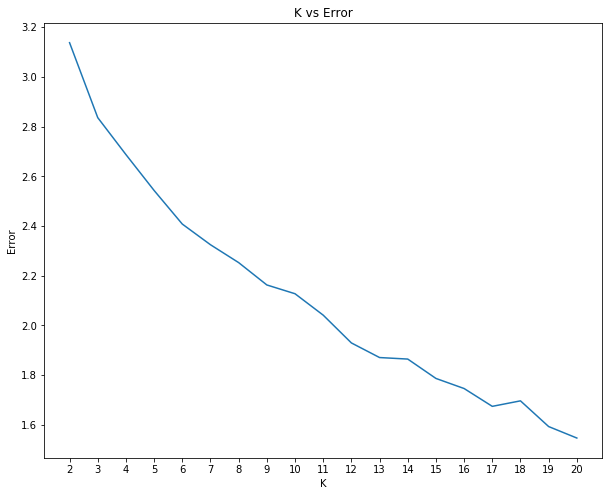

In [75]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

From the above visualization, we can say that the speed at which error reduces falls after K=9


In [76]:
# train final model with k=9
kmeans = KMeans(n_clusters=9)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [77]:
kmeans.labels_[:10]


array([1, 4, 2, 2, 4, 0, 3, 0, 3, 3], dtype=int32)

<b><i>Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.¶


In [79]:
# add clustering labels
nbr_venues_sorted_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [80]:
toronto_nbr_df = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_nbr_df = toronto_nbr_df.join(nbr_venues_sorted_df.set_index('Neighborhood'), on='Neighborhood')

toronto_nbr_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4,Office,Factory,Automotive Shop,Medical Center,Doctor's Office,Dentist's Office,Building,Coffee Shop,Salon / Barbershop,Fried Chicken Joint
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,3,Automotive Shop,Office,Medical Center,General Entertainment,Park,Nail Salon,Salon / Barbershop,Miscellaneous Shop,Laundry Service,Dentist's Office
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,3,Electronics Store,Residential Building (Apartment / Condo),Restaurant,Church,Bus Line,School,Building,Bus Stop,Bank,Salon / Barbershop
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,Cosmetics Shop,Convenience Store,Pharmacy,Pizza Place,Bus Stop,Bus Line,Residential Building (Apartment / Condo),Salon / Barbershop,Building,Coffee Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,4,Bakery,Doctor's Office,Medical Center,Building,Residential Building (Apartment / Condo),Laundry Service,Office,Automotive Shop,Pool,Pharmacy


<b><i>Finally, let's visualize the resulting clusters


In [81]:
# create map
map_clusters = folium.Map(location=toronto_latlong, zoom_start=11)

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_nbr_df['Latitude'], toronto_nbr_df['Longitude'], toronto_nbr_df['Neighborhood'], toronto_nbr_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [82]:
HTML(map_clusters._repr_html_())


<h1><b>Examining Clusters


Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

<h1><b>Cluster 0


In [85]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 0, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Don Mills,0,Office,Building,Medical Center,General College & University,Coworking Space,Café,School,Tech Startup,Doctor's Office,Church
27,Don Mills,0,Office,Building,Medical Center,General College & University,Coworking Space,Café,School,Tech Startup,Doctor's Office,Church
53,"Regent Park, Harbourfront",0,Office,Automotive Shop,Auto Dealership,Italian Restaurant,Coffee Shop,Building,Art Gallery,Design Studio,Assisted Living,Hardware Store
55,St. James Town,0,Office,Building,Residential Building (Apartment / Condo),Tech Startup,Event Space,Design Studio,Coworking Space,Japanese Restaurant,Church,Thai Restaurant
56,Berczy Park,0,Office,Building,Tech Startup,Residential Building (Apartment / Condo),Hotel,Assisted Living,Laundry Service,Breakfast Spot,Rental Car Location,Sandwich Place
58,"Richmond, Adelaide, King",0,Office,Building,Café,Coffee Shop,Italian Restaurant,Indian Restaurant,Hotel,Financial or Legal Service,Tech Startup,Pool
60,"Toronto Dominion Centre, Design Exchange",0,Office,Café,Restaurant,Park,Coffee Shop,Building,Coworking Space,Cosmetics Shop,Tech Startup,Italian Restaurant
61,"Commerce Court, Victoria Hotel",0,Office,Financial or Legal Service,Bank,Salon / Barbershop,Coffee Shop,Bus Stop,Building,Restaurant,Bakery,Dentist's Office
69,Stn A PO Boxes,0,Office,Building,Tech Startup,Residential Building (Apartment / Condo),Bar,Hotel,Gym,Café,Japanese Restaurant,Grocery Store
78,"Brockton, Parkdale Village, Exhibition Place",0,Office,Residential Building (Apartment / Condo),Tech Startup,Building,Coworking Space,Convenience Store,Coffee Shop,Café,Gym / Fitness Center,Dentist's Office


<h1><b>Cluster 1


In [87]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 1, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough Village,1,Residential Building (Apartment / Condo),Automotive Shop,Building,Pizza Place,Gas Station,Convenience Store,Church,Gym / Fitness Center,Salon / Barbershop,College Academic Building
10,"Dorset Park, Wexford Heights, Scarborough Town...",1,Automotive Shop,Building,Office,Electronics Store,Auto Garage,Factory,Bakery,Hardware Store,Design Studio,Miscellaneous Shop
12,Agincourt,1,Automotive Shop,Building,Office,Church,Doctor's Office,Coffee Shop,Storage Facility,Auto Garage,Gas Station,Rental Car Location
81,"Runnymede, The Junction North",1,Automotive Shop,Miscellaneous Shop,Breakfast Spot,Event Space,Park,Financial or Legal Service,Pizza Place,Residential Building (Apartment / Condo),Gas Station,Doctor's Office
96,Humber Summit,1,Automotive Shop,Gas Station,Church,Rental Car Location,Building,Italian Restaurant,Bank,Bakery,Pizza Place,Office
97,"Humberlea, Emery",1,Building,Factory,Hardware Store,Church,Residential Building (Apartment / Condo),Bank,Coffee Shop,Housing Development,General Entertainment,Storage Facility


<h1><b>Cluster 2

In [89]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 2, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Kennedy Park, Ionview, East Birchmount Park",2,Dentist's Office,Coffee Shop,Residential Building (Apartment / Condo),Pizza Place,Doctor's Office,Chinese Restaurant,Bus Line,Church,School,Office
8,"Cliffside, Cliffcrest, Scarborough Village West",2,Pizza Place,Residential Building (Apartment / Condo),Office,Convenience Store,Salon / Barbershop,School,Church,Laundry Service,Dentist's Office,Bank
13,"Clarks Corners, Tam O'Shanter, Sullivan",2,Doctor's Office,Automotive Shop,Bank,Gas Station,Chinese Restaurant,Dentist's Office,Convenience Store,Pizza Place,Church,Bus Line
15,"Steeles West, L'Amoreaux West",2,Doctor's Office,Dentist's Office,Chinese Restaurant,Bank,Office,Residential Building (Apartment / Condo),Clothing Store,Salon / Barbershop,Church,Park
17,Hillcrest Village,2,School,Residential Building (Apartment / Condo),Housing Development,Medical Center,Bank,Bus Line,Pizza Place,Park,High School,Coffee Shop
19,Bayview Village,2,Residential Building (Apartment / Condo),Church,Doctor's Office,Office,Salon / Barbershop,Bank,Dog Run,Medical Center,Playground,Optical Shop
21,"Willowdale, Newtonbrook",2,Church,Medical Center,Bank,Office,Park,Bus Line,Korean Restaurant,Coffee Shop,Salon / Barbershop,School
28,"Bathurst Manor, Wilson Heights, Downsview North",2,Doctor's Office,Residential Building (Apartment / Condo),Office,Medical Center,Bank,Salon / Barbershop,Building,Convenience Store,Dentist's Office,Non-Profit
30,Downsview,2,Residential Building (Apartment / Condo),Building,Park,Office,Elementary School,Bank,Coffee Shop,Medical Center,Doctor's Office,Church
31,Downsview,2,Residential Building (Apartment / Condo),Building,Park,Office,Elementary School,Bank,Coffee Shop,Medical Center,Doctor's Office,Church


<h1><b>Cluster 3

In [90]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 3, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Rouge Hill, Port Union, Highland Creek",3,Automotive Shop,Office,Medical Center,General Entertainment,Park,Nail Salon,Salon / Barbershop,Miscellaneous Shop,Laundry Service,Dentist's Office
2,"Guildwood, Morningside, West Hill",3,Electronics Store,Residential Building (Apartment / Condo),Restaurant,Church,Bus Line,School,Building,Bus Stop,Bank,Salon / Barbershop
3,Woburn,3,Cosmetics Shop,Convenience Store,Pharmacy,Pizza Place,Bus Stop,Bus Line,Residential Building (Apartment / Condo),Salon / Barbershop,Building,Coffee Shop
7,"Golden Mile, Clairlea, Oakridge",3,Bus Line,Park,Automotive Shop,Residential Building (Apartment / Condo),Convenience Store,Bakery,Pharmacy,Office,Bus Station,Chinese Restaurant
9,"Birch Cliff, Cliffside West",3,Church,General Entertainment,Park,Office,Indian Restaurant,Bus Stop,Bus Line,Laundry Service,Building,Government Building
14,"Milliken, Agincourt North, Steeles East, L'Amo...",3,Chinese Restaurant,School,Medical Center,Doctor's Office,BBQ Joint,Building,Park,Church,Fast Food Restaurant,Pizza Place
16,Upper Rouge,3,Zoo Exhibit,Office,Cosmetics Shop,Park,Playground,Art Gallery,Auto Dealership,General Entertainment,Pizza Place,Pharmacy
35,"Parkview Hill, Woodbine Gardens",3,Bus Stop,Office,Building,Convenience Store,Café,Fast Food Restaurant,Bank,Dentist's Office,Pet Store,Sandwich Place
36,Woodbine Heights,3,Bus Stop,Office,Café,Park,Building,Church,Bus Line,Laundry Service,Design Studio,Pizza Place
40,East Toronto,3,Coffee Shop,Park,Café,Pizza Place,Church,Office,Caribbean Restaurant,Bus Stop,Building,High School


<h1><b>Cluster 4

In [91]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 4, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",4,Office,Factory,Automotive Shop,Medical Center,Doctor's Office,Dentist's Office,Building,Coffee Shop,Salon / Barbershop,Fried Chicken Joint
4,Cedarbrae,4,Bakery,Doctor's Office,Medical Center,Building,Residential Building (Apartment / Condo),Laundry Service,Office,Automotive Shop,Pool,Pharmacy
11,"Wexford, Maryvale",4,Middle Eastern Restaurant,Medical Center,Office,Grocery Store,Coffee Shop,Hookah Bar,Café,Pizza Place,Dentist's Office,Bakery
29,"Northwood Park, York University",4,Office,Automotive Shop,Building,Gas Station,Pharmacy,Medical Center,Salon / Barbershop,Caribbean Restaurant,Cosmetics Shop,Pizza Place
38,Leaside,4,Bank,Office,Dentist's Office,Coffee Shop,Building,Automotive Shop,Sandwich Place,School,Shopping Mall,Breakfast Spot
39,Thorncliffe Park,4,Office,Church,Residential Building (Apartment / Condo),Bank,Indian Restaurant,Fast Food Restaurant,Sandwich Place,Middle Eastern Restaurant,Coffee Shop,Pizza Place
41,"The Danforth West, Riverdale",4,Greek Restaurant,Salon / Barbershop,Spa,Office,Medical Center,Gym / Fitness Center,Cosmetics Shop,Miscellaneous Shop,Park,Elementary School
43,Studio District,4,Building,Coffee Shop,Office,Pharmacy,Dentist's Office,Café,Spa,Automotive Shop,Nail Salon,Doctor's Office
48,"Moore Park, Summerhill East",4,Building,Office,Residential Building (Apartment / Condo),Government Building,Park,Gym,Playground,Trail,Bank,Grocery Store
51,"St. James Town, Cabbagetown",4,Café,Coffee Shop,Office,Pizza Place,Pharmacy,Pet Store,Restaurant,Residential Building (Apartment / Condo),Spa,Bakery


<h1><b>Cluster 5

In [92]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 5, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
85,"Queen's Park, Ontario Provincial Government",5,Government Building,Medical Center,Building,Restaurant,Office,Doctor's Office,Church,School,Sandwich Place,Convenience Store


<h1><b>Cluster 6

In [93]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 6, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"York Mills, Silver Hills",6,Residential Building (Apartment / Condo),Park,Church,High School,Pool,School,Optical Shop,Coffee Shop,College Academic Building,Bus Line
22,Willowdale,6,Residential Building (Apartment / Condo),Bank,Park,Office,Salon / Barbershop,Medical Center,Coffee Shop,Building,Pizza Place,Restaurant
23,York Mills West,6,Residential Building (Apartment / Condo),Office,Gym,Park,Building,Government Building,Medical Center,Laundry Service,Church,Rental Car Location
24,Willowdale,6,Residential Building (Apartment / Condo),Bank,Park,Office,Salon / Barbershop,Medical Center,Coffee Shop,Building,Pizza Place,Restaurant
25,Parkwoods,6,Residential Building (Apartment / Condo),Bus Stop,Park,School,Office,Elementary School,Convenience Store,Sandwich Place,Pool,Spiritual Center
34,Victoria Village,6,Residential Building (Apartment / Condo),Office,Automotive Shop,Bus Stop,Building,Park,Bank,Government Building,Playground,Auto Dealership
45,Davisville North,6,Residential Building (Apartment / Condo),Office,Gym,Dog Run,Scenic Lookout,Medical Center,Building,Dentist's Office,Breakfast Spot,Pool
49,"Summerhill West, Rathnelly, South Hill, Forest...",6,Office,Residential Building (Apartment / Condo),Doctor's Office,Building,Medical Center,Dentist's Office,Tech Startup,Café,Government Building,Italian Restaurant
50,Rosedale,6,Residential Building (Apartment / Condo),Office,Park,Building,Trail,Government Building,Salon / Barbershop,Dog Run,General Travel,Bank
52,Church and Wellesley,6,Residential Building (Apartment / Condo),Office,Building,Doctor's Office,Gym,Gym / Fitness Center,Spa,Thrift / Vintage Store,Hotel,Smoke Shop


<h1><b>Cluster 7

In [94]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 7, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Fairview, Henry Farm, Oriole",7,Clothing Store,Optical Shop,Doctor's Office,Electronics Store,Jewelry Store,Cosmetics Shop,Medical Center,Bus Stop,Bank,Restaurant
46,North Toronto West,7,Clothing Store,Health & Beauty Service,Cosmetics Shop,Dentist's Office,Church,Italian Restaurant,Spa,Office,Coffee Shop,General Entertainment
71,"Lawrence Manor, Lawrence Heights",7,Clothing Store,Office,Design Studio,Miscellaneous Shop,Cosmetics Shop,Factory,Automotive Shop,Athletics & Sports,Event Space,Skating Rink


<h1><b>Cluster 8

In [95]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 8, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Roselawn,8,Dentist's Office,Office,Doctor's Office,Gym,Spa,Playground,General Entertainment,Medical Center,High School,Residential Building (Apartment / Condo)
64,Forest Hill North & West,8,Dentist's Office,Office,Doctor's Office,Tech Startup,Medical Center,General Entertainment,Park,Gym / Fitness Center,College Academic Building,High School
84,"Runnymede, Swansea",8,Dentist's Office,Medical Center,Doctor's Office,Office,Salon / Barbershop,Nail Salon,Optical Shop,Bakery,Pizza Place,Spa
